# Multi-Class Image Classification Deep Learning Model for ISIC 2018 Challenge Using TensorFlow Take 3
### David Lowe
### October 27, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The ISIC Challenge 2018 dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The International Skin Imaging Collaboration (ISIC) is an international effort to improve melanoma diagnosis, sponsored by the International Society for Digital Imaging of the Skin (ISDIS). The ISIC Archive contains the most extensive publicly available collection of quality-controlled dermoscopic images of skin lesions. Since 2016, ISIC has sponsored annual challenges for the computer science community associated with leading computer vision conferences.

For this modeling project, we will predict whether an image represents one of seven disease conditions (Task 3: Lesion Diagnosis). In this iteration, we will construct a CNN model based on the VGG19 architecture to make predictions.

ANALYSIS: In this iteration, the VGG19 model's performance achieved a categorical accuracy score of 81.37% after ten epochs using the training dataset. The same model processed the validation dataset with a categorical accuracy rate of 84.97%.

CONCLUSION: In this iteration, the VGG19-based CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: ISIC 2018 Challenge Dataset

Dataset ML Model: Multi-Class classification with numerical attributes

Dataset Reference: https://challenge.isic-archive.com/data

One potential source of performance benchmarks: https://challenge.isic-archive.com/leaderboards/2018

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sat Oct 23 18:33:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
# Load libraries and packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
from datetime import datetime
import zipfile
import h5py
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
VAL_SET_RATIO = 0.2
# TEST_SET_RATIO = 0.5

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
# DEFAULT_METRICS = ['accuracy']
DEFAULT_METRICS = [tf.keras.metrics.CategoricalAccuracy()]
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.00005)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 10
BATCH_SIZE = 32
# RAW_IMAGE_SIZE = (100, 100)
TARGET_IMAGE_SIZE = (224, 224)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

CLASS_LABELS = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']
CLASS_NAMES = ['Melanoma','Melanocytic nevus','Basal cell carcinoma',
               'Actinic keratosis','Benign keratosis',
               'Dermatofibroma','Vascular lesion']
NUM_CLASSES = len(CLASS_LABELS)  # 1 for binary classification

# Define the labels to use for graphing the data
train_metric = "categorical_accuracy"
validation_metric = "val_categorical_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'staging/ISIC2018_Task3_Training_Input/'
VALID_DIR = 'staging/ISIC2018_Task3_Validation_Input/'
# TEST_DIR = ''
TRAIN_DATASET = 'ISIC2018_Task3_Training_Input.zip'
VALID_DATASET = 'ISIC2018_Task3_Validation_Input.zip'
# TEST_DATASET = ''
TRAIN_LABELS = 'ISIC2018_Task3_Training_GroundTruth.csv'
VALID_LABELS = 'ISIC2018_Task3_Validation_GroundTruth.csv'
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Number of GPUs detected by TensorFlow:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Number of GPUs detected by TensorFlow: 1
TensorFlow version: 2.6.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [10]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [12]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [13]:
# Create a staging directory to hold all images
!rm -rf staging/
!mkdir staging/

In [14]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/isic-challenge-2018/ISIC2018_Task3_Training_Input.zip

--2021-10-23 18:33:27--  https://dainesanalytics.com/datasets/isic-challenge-2018/ISIC2018_Task3_Training_Input.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 18.66.248.117, 18.66.248.22, 18.66.248.2, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|18.66.248.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2771732744 (2.6G) [application/zip]
Saving to: ‘ISIC2018_Task3_Training_Input.zip’

ISIC2018_Task3_Trai 100%[===================>]   2.58G  36.0MB/s    in 77s     

2021-10-23 18:34:45 (34.3 MB/s) - ‘ISIC2018_Task3_Training_Input.zip’ saved [2771732744/2771732744]



In [15]:
zip_ref = zipfile.ZipFile(TRAIN_DATASET, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [16]:
# Delete the non-essential files from the image directory
!rm staging/ISIC2018_Task3_Training_Input/ATTRIBUTION.txt
!rm staging/ISIC2018_Task3_Training_Input/LICENSE.txt

In [17]:
if not os.path.exists(VALID_DATASET):
    !wget https://dainesanalytics.com/datasets/isic-challenge-2018/ISIC2018_Task3_Validation_Input.zip

--2021-10-23 18:35:06--  https://dainesanalytics.com/datasets/isic-challenge-2018/ISIC2018_Task3_Validation_Input.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 18.66.248.117, 18.66.248.92, 18.66.248.2, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|18.66.248.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53292381 (51M) [application/zip]
Saving to: ‘ISIC2018_Task3_Validation_Input.zip’

ISIC2018_Task3_Vali 100%[===================>]  50.82M  17.2MB/s    in 3.0s    

2021-10-23 18:35:09 (17.2 MB/s) - ‘ISIC2018_Task3_Validation_Input.zip’ saved [53292381/53292381]



In [18]:
zip_ref = zipfile.ZipFile(VALID_DATASET, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [19]:
# Delete the non-essential files from the image directory
!rm staging/ISIC2018_Task3_Validation_Input/ATTRIBUTION.txt
!rm staging/ISIC2018_Task3_Validation_Input/LICENSE.txt

In [20]:
dataset_path = 'https://dainesanalytics.com/datasets/isic-challenge-2018/ISIC2018_Task3_Training_GroundTruth.csv'
df_training = pd.read_csv(dataset_path, index_col=False)
df_training['image'] = df_training['image'] + '.jpg'
df_training['MEL'] = df_training['MEL'].astype(bool)
df_training['NV'] = df_training['NV'].astype(bool)
df_training['BCC'] = df_training['BCC'].astype(bool)
df_training['AKIEC'] = df_training['AKIEC'].astype(bool)
df_training['BKL'] = df_training['BKL'].astype(bool)
df_training['DF'] = df_training['DF'].astype(bool)
df_training['VASC'] = df_training['VASC'].astype(bool)
df_training['class'] = CLASS_LABELS[0]
df_training['class'].loc[df_training['NV']] = CLASS_LABELS[1]
df_training['class'].loc[df_training['BCC']] = CLASS_LABELS[2]
df_training['class'].loc[df_training['AKIEC']] = CLASS_LABELS[3]
df_training['class'].loc[df_training['BKL']] = CLASS_LABELS[4]
df_training['class'].loc[df_training['DF']] = CLASS_LABELS[5]
df_training['class'].loc[df_training['VASC']] = CLASS_LABELS[6]

# Take a peek at the dataframe after import
print(df_training.head(20))

               image    MEL     NV    BCC  AKIEC    BKL     DF   VASC class
0   ISIC_0024306.jpg  False   True  False  False  False  False  False    NV
1   ISIC_0024307.jpg  False   True  False  False  False  False  False    NV
2   ISIC_0024308.jpg  False   True  False  False  False  False  False    NV
3   ISIC_0024309.jpg  False   True  False  False  False  False  False    NV
4   ISIC_0024310.jpg   True  False  False  False  False  False  False   MEL
5   ISIC_0024311.jpg  False   True  False  False  False  False  False    NV
6   ISIC_0024312.jpg  False  False  False  False   True  False  False   BKL
7   ISIC_0024313.jpg   True  False  False  False  False  False  False   MEL
8   ISIC_0024314.jpg  False   True  False  False  False  False  False    NV
9   ISIC_0024315.jpg   True  False  False  False  False  False  False   MEL
10  ISIC_0024316.jpg  False   True  False  False  False  False  False    NV
11  ISIC_0024317.jpg  False   True  False  False  False  False  False    NV
12  ISIC_002

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [21]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR)
    training_class_files = df_training['image'][df_training['class']==c_label]
    print('Number of training images for', c_label, ':', len(training_class_files))
    print('Training samples for', c_label, ':')
    print(training_class_files[:5],'\n')

Number of training images for MEL : 1113
Training samples for MEL :
4     ISIC_0024310.jpg
7     ISIC_0024313.jpg
9     ISIC_0024315.jpg
17    ISIC_0024323.jpg
27    ISIC_0024333.jpg
Name: image, dtype: object 

Number of training images for NV : 6705
Training samples for NV :
0    ISIC_0024306.jpg
1    ISIC_0024307.jpg
2    ISIC_0024308.jpg
3    ISIC_0024309.jpg
5    ISIC_0024311.jpg
Name: image, dtype: object 

Number of training images for BCC : 514
Training samples for BCC :
25    ISIC_0024331.jpg
26    ISIC_0024332.jpg
39    ISIC_0024345.jpg
54    ISIC_0024360.jpg
97    ISIC_0024403.jpg
Name: image, dtype: object 

Number of training images for AKIEC : 327
Training samples for AKIEC :
23     ISIC_0024329.jpg
66     ISIC_0024372.jpg
112    ISIC_0024418.jpg
144    ISIC_0024450.jpg
157    ISIC_0024463.jpg
Name: image, dtype: object 

Number of training images for BKL : 1099
Training samples for BKL :
6     ISIC_0024312.jpg
18    ISIC_0024324.jpg
30    ISIC_0024336.jpg
31    ISIC_0024

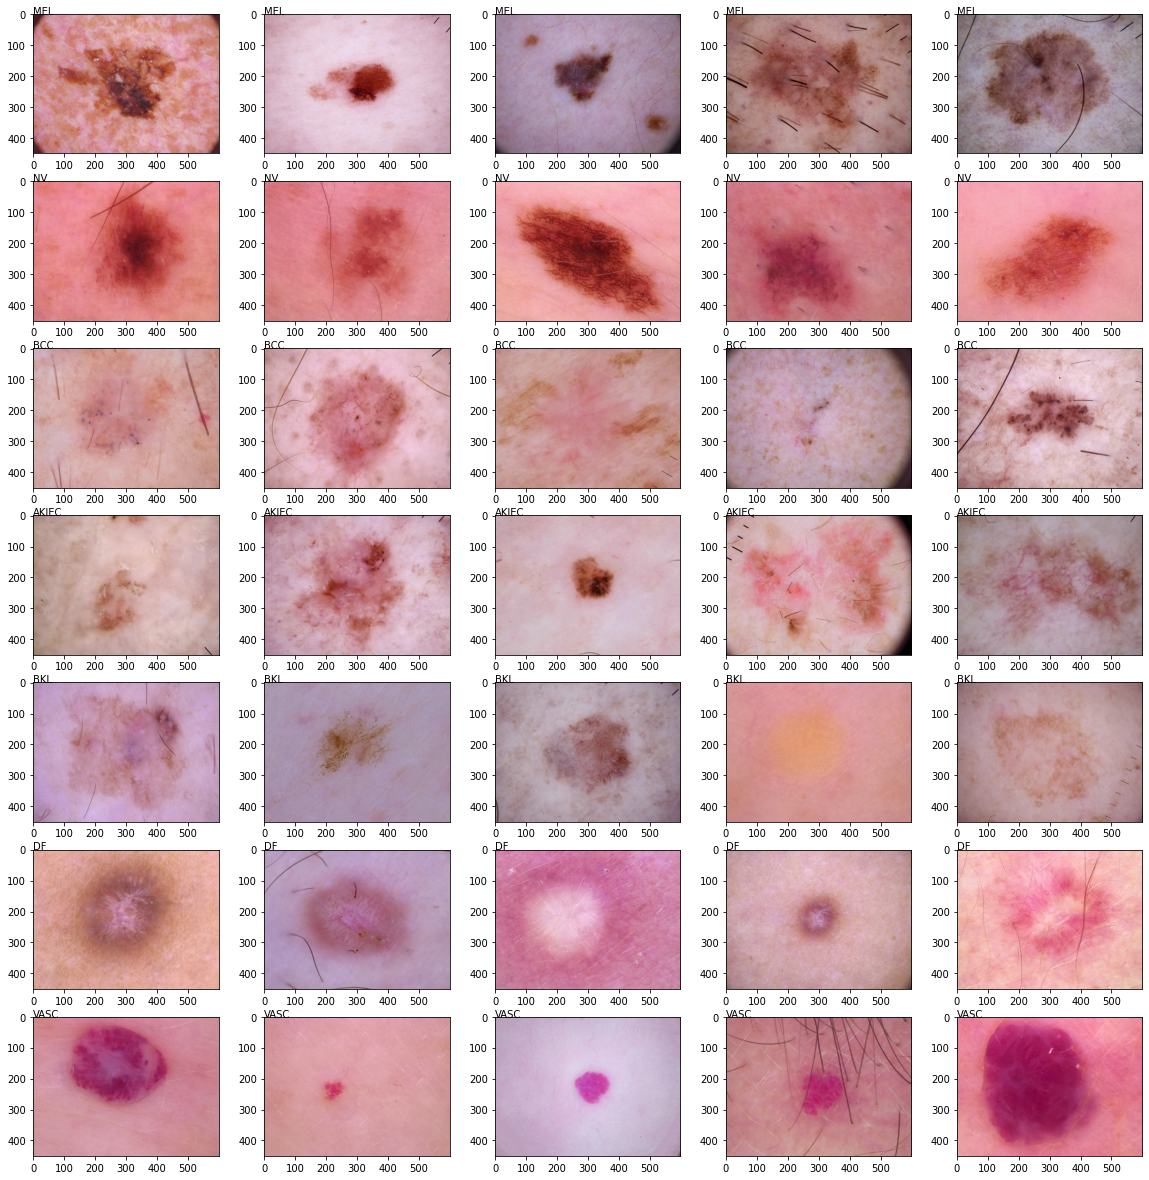

In [22]:
# Plot some training images from the dataset
nrows = 7
ncols = 5
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR)
    training_class_files = df_training['image'][df_training['class']==c_label]
    for j in range(ncols):
        training_examples.append(training_class_files.iloc[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(TRAIN_DIR + img_path)
    plt.imshow(img)
plt.show()

In [23]:
dataset_path = 'https://dainesanalytics.com/datasets/isic-challenge-2018/ISIC2018_Task3_Validation_GroundTruth.csv'
df_validation = pd.read_csv(dataset_path, index_col=False)
df_validation['image'] = df_validation['image'] + '.jpg'
df_validation['MEL'] = df_validation['MEL'].astype(bool)
df_validation['NV'] = df_validation['NV'].astype(bool)
df_validation['BCC'] = df_validation['BCC'].astype(bool)
df_validation['AKIEC'] = df_validation['AKIEC'].astype(bool)
df_validation['BKL'] = df_validation['BKL'].astype(bool)
df_validation['DF'] = df_validation['DF'].astype(bool)
df_validation['VASC'] = df_validation['VASC'].astype(bool)
df_validation['class'] = CLASS_LABELS[0]
df_validation['class'].loc[df_validation['NV']] = CLASS_LABELS[1]
df_validation['class'].loc[df_validation['BCC']] = CLASS_LABELS[2]
df_validation['class'].loc[df_validation['AKIEC']] = CLASS_LABELS[3]
df_validation['class'].loc[df_validation['BKL']] = CLASS_LABELS[4]
df_validation['class'].loc[df_validation['DF']] = CLASS_LABELS[5]
df_validation['class'].loc[df_validation['VASC']] = CLASS_LABELS[6]

# Take a peek at the dataframe after import
print(df_validation.head(10))

              image    MEL     NV    BCC  AKIEC    BKL     DF   VASC class
0  ISIC_0034321.jpg  False   True  False  False  False  False  False    NV
1  ISIC_0034322.jpg  False   True  False  False  False  False  False    NV
2  ISIC_0034323.jpg  False  False   True  False  False  False  False   BCC
3  ISIC_0034324.jpg  False   True  False  False  False  False  False    NV
4  ISIC_0034325.jpg  False   True  False  False  False  False  False    NV
5  ISIC_0034326.jpg  False  False  False  False   True  False  False   BKL
6  ISIC_0034328.jpg  False   True  False  False  False  False  False    NV
7  ISIC_0034329.jpg   True  False  False  False  False  False  False   MEL
8  ISIC_0034330.jpg  False   True  False  False  False  False  False    NV
9  ISIC_0034331.jpg  False   True  False  False  False  False  False    NV


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [24]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(VALID_DIR)
    training_class_files = df_validation['image'][df_validation['class']==c_label]
    print('Number of training images for', c_label, ':', len(training_class_files))
    print('Training samples for', c_label, ':')
    print(training_class_files[:5],'\n')

Number of training images for MEL : 21
Training samples for MEL :
7     ISIC_0034329.jpg
21    ISIC_0034343.jpg
31    ISIC_0034354.jpg
51    ISIC_0034376.jpg
56    ISIC_0034381.jpg
Name: image, dtype: object 

Number of training images for NV : 123
Training samples for NV :
0    ISIC_0034321.jpg
1    ISIC_0034322.jpg
3    ISIC_0034324.jpg
4    ISIC_0034325.jpg
6    ISIC_0034328.jpg
Name: image, dtype: object 

Number of training images for BCC : 15
Training samples for BCC :
2     ISIC_0034323.jpg
11    ISIC_0034333.jpg
16    ISIC_0034338.jpg
22    ISIC_0034344.jpg
24    ISIC_0034346.jpg
Name: image, dtype: object 

Number of training images for AKIEC : 8
Training samples for AKIEC :
10    ISIC_0034332.jpg
69    ISIC_0034396.jpg
75    ISIC_0034402.jpg
83    ISIC_0034410.jpg
94    ISIC_0034421.jpg
Name: image, dtype: object 

Number of training images for BKL : 22
Training samples for BKL :
5     ISIC_0034326.jpg
23    ISIC_0034345.jpg
36    ISIC_0034360.jpg
38    ISIC_0034362.jpg
42   

In [25]:
datagen_kwargs = dict(rescale=1./255)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="categorical")

do_data_augmentation = True
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=90,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_dataframe(df_training,
                                                          directory=TRAIN_DIR,
                                                          x_col='image',
                                                          y_col='class',
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          **dataflow_kwargs)
print('Number of training batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_dataframe(df_validation,
                                                              directory=VALID_DIR,
                                                              x_col='image',
                                                              y_col='class',
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              **dataflow_kwargs)
print('Number of validation batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 10015 validated image filenames belonging to 7 classes.
Number of training batches per epoch of modeling: 313
Loading and pre-processing the validation images...
Found 193 validated image filenames belonging to 7 classes.
Number of validation batches per epoch of modeling: 7


In [26]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [27]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [28]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Training')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == train_loss:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0.5, 1.1])
        plt.legend()

In [29]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, dense_nodes=2048,
                    init_param=DEFAULT_INITIALIZER, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=input_param)
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param)),
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [30]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
reset_random()
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(training_generator,
                                  epochs=MAX_EPOCHS,
                                  validation_data=validation_generator,
                                #   callbacks=[learning_rate_reduction],
                                  verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

80150528/80134624 [==============================] - 2s 0us/step
Epoch 1/10
313/313 [==============================] - 225s 654ms/step - loss: 1.0016 - categorical_accuracy: 0.6769 - val_loss: 0.7027 - val_categorical_accuracy: 0.7876
Epoch 2/10
313/313 [==============================] - 202s 646ms/step - loss: 0.7768 - categorical_accuracy: 0.7199 - val_loss: 0.6363 - val_categorical_accuracy: 0.7876
Epoch 3/10
313/313 [==============================] - 201s 641ms/step - loss: 0.6942 - categorical_accuracy: 0.7416 - val_loss: 0.6822 - val_categorical_accuracy: 0.7876
Epoch 4/10
313/313 [==============================] - 201s 641ms/step - loss: 0.6352 - categorical_accuracy: 0.7655 - val_loss: 0.5564 - val_categorical_accuracy: 0.8083
Epoch 5/10
313/313 [==============================] - 201s 642ms/step - loss: 0.6151 - categorical_accuracy: 0.7726 - val_loss: 0.5233 - val_categorical_accuracy: 0.8083
Epoch 6/10
313/313 [==============================] - 200s 639ms/step - loss: 0.5795 

In [31]:
nn_model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14343     
Total params: 71,420,999
Trainable params: 71,420,999
Non-trainable params: 0
_________________________________________________________________


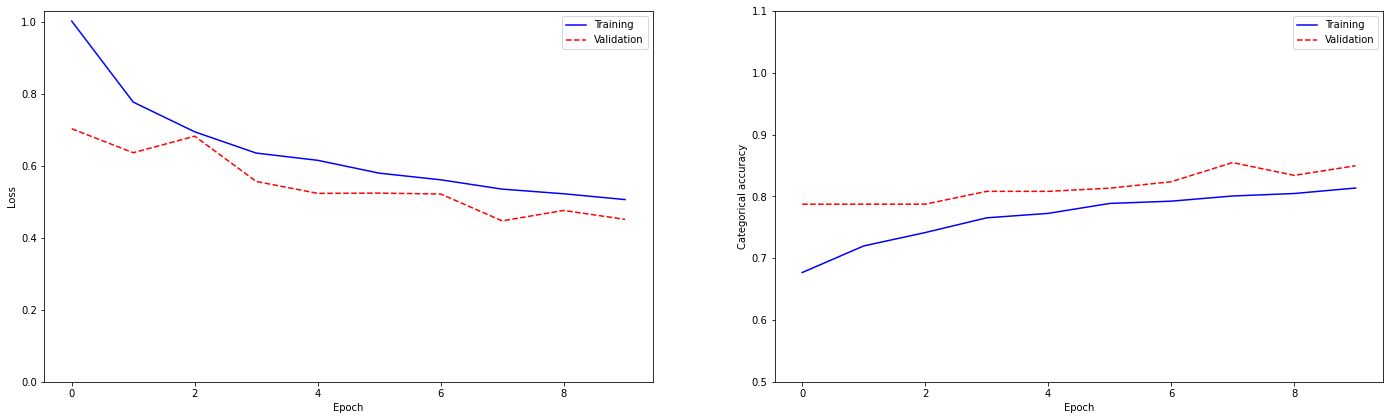

In [32]:
plot_metrics(nn_model_history)

In [33]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [34]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [35]:
# Not applicable for this iteration of modeling

In [36]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [37]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [38]:
# Not applicable for this iteration of modeling

In [39]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [40]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:35:42.893721
